## Importing Libraries

In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
import mplfinance as mpf
##import pandas_ta as ta

## Importing Data

In [176]:
def get_data(ticker, interval='1d', period='10y'):
    data = yf.download(ticker, interval=interval, period=period, rounding=True, multi_level_index=False)
    return data


df = get_data('AAPL', interval='1d', period='10y')

[*********************100%***********************]  1 of 1 completed


In [177]:
df.head()

,Close,High,Low,Open,Volume
Date,,,,,
2015-03-05,28.23,28.75,28.09,28.72,226068400
2015-03-06,28.27,28.89,28.20,28.68,291368400
2015-03-09,28.39,28.94,27.93,28.58,354114000
2015-03-10,27.81,28.41,27.65,28.23,275426400
2015-03-11,27.30,27.86,27.27,27.86,275756000


## Price Chart

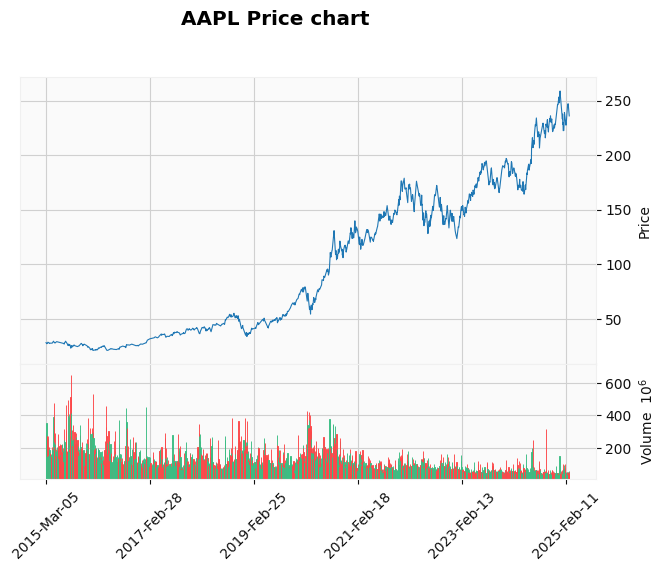

In [178]:
def price_chart(df, type='line', volume=True, style='yahoo', title='AAPL Price chart'):
    #df.columns = df.columns.droplevel(1)
    df.index = pd.to_datetime(df.index)
    mpf.plot(df, type=type, volume=volume, style=style, title=title)


price_chart(df)

## Generating Technical Indicators

In [179]:
df.ta.rsi(length=14, append=True)
df.ta.ema(length=20, append=True)
df.ta.ema(length=50, append=True)
df.ta.ema(length=200, append=True)

# drop rows with NaN values because of shift in EMA calculation
df.dropna(inplace=True)

df.tail()

,Close,High,Low,Open,Volume,RSI_14,EMA_20,EMA_50,EMA_200
Date,,,,,,,,,
2025-02-26,240.36,244.98,239.13,244.33,44433600,51.633513,239.992732,238.060603,223.983914
2025-02-27,237.30,242.46,237.06,239.41,41153600,47.438877,239.736281,238.030775,224.116412
2025-02-28,241.84,242.09,230.20,236.95,56833400,53.477584,239.936635,238.180156,224.292766
2025-03-03,238.03,244.03,236.11,241.79,47184000,48.447193,239.755051,238.174268,224.429455
2025-03-04,235.93,240.07,234.68,237.71,53724800,45.885179,239.390761,238.086257,224.543888


## Defining entry points

In [180]:
df["good_entry"] = (
    (df["RSI_14"] < 45) &  
    (df["EMA_20"] > 0.99 * df["EMA_50"]) &  
    (df["Close"] >= 0.95 * df["EMA_200"])
).astype(int)

#df.to_csv('AAPL.csv')

df['good_entry'].value_counts()

good_entry
0    2024
1     292
Name: count, dtype: int64

<Axes: >

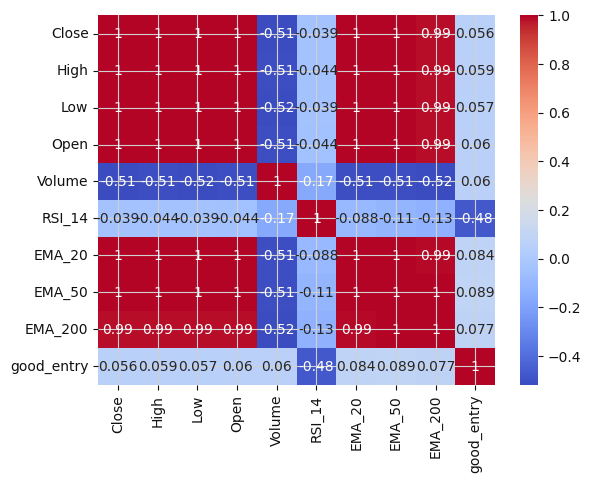

In [190]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

## Classifying the data

In [182]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

### Data splitting

In [183]:
X = df.drop(columns=['good_entry'])
y = df['good_entry']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)



### Model training

In [184]:
classifier = RandomForestClassifier(n_estimators=50, random_state=42)
classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

### Model evaluation

In [185]:
y_pred = classifier.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       405
           1       0.93      0.95      0.94        59

    accuracy                           0.98       464
   macro avg       0.96      0.97      0.97       464
weighted avg       0.99      0.98      0.98       464



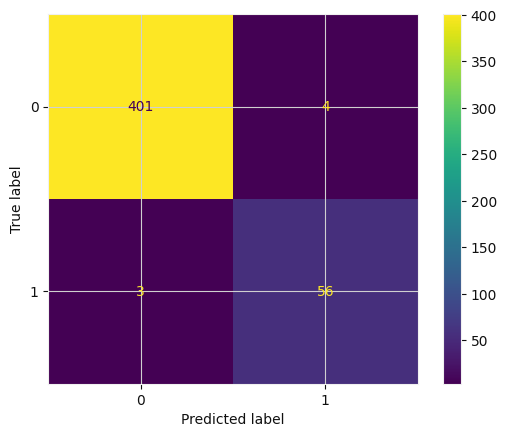

In [186]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### features importance

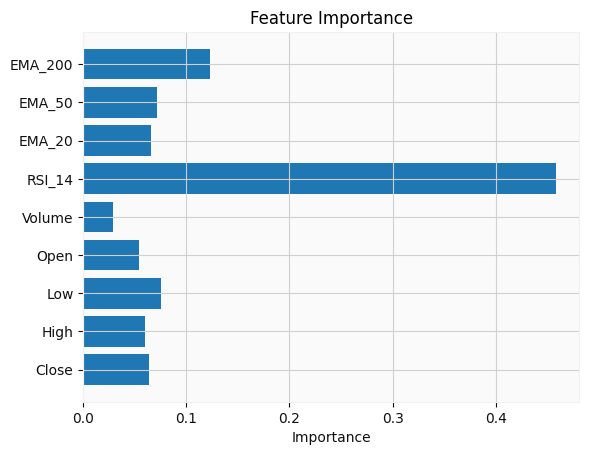

In [187]:
plt.barh(X.columns, classifier.feature_importances_)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()